최소 길이 : 224
데이터 개수 : 329
1    329
0     32
dtype: int64
등장 빈도가 1 이하인 희귀 단어의 수: 1032
단어 집합에서 희귀 단어의 비율: 43.39781328847771
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5658754016792784
단어 집합의 크기: 2379
훈련 데이터 개수 : 288
테스트 데이터 개수 : 73
메일의 최대 길이 : 110
메일의 평균 길이 : 80.168975


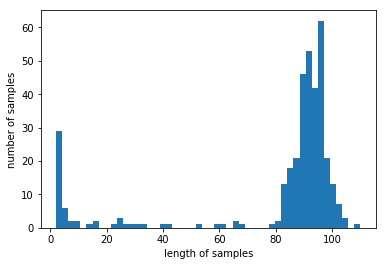

훈련 데이터의 크기(shape):  (361, 2747)
Epoch 1/5
4/4 [==============================] - 3s 724ms/step - loss: 0.6566 - acc: 0.6174 - val_acc: 1.0000 - val_loss: 0.5006
Epoch 2/5
4/4 [==============================] - 3s 694ms/step - loss: 0.5202 - acc: 0.9435 - val_acc: 0.8448 - val_loss: 0.5991
Epoch 3/5
4/4 [==============================] - 3s 670ms/step - loss: 0.4390 - acc: 0.9957 - val_acc: 1.0000 - val_loss: 0.5065
Epoch 4/5
4/4 [==============================] - 3s 690ms/step - loss: 0.3971 - acc: 1.0000 - val_acc: 1.0000 - val_loss: 0.4793
Epoch 5/5
3/3 [==============================] - 0s 48ms/step - loss: 0.6779 - acc: 0.5616

 테스트 정확도: 0.5616


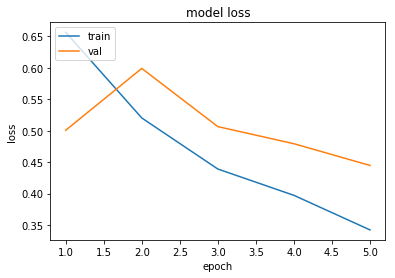

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas import Series
import re
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

temp_list = []
x_list = []
y_list = []
min = 99999
n = 32

# Read spam Data
for i in range(n):
    path = 'textfile/'+str(i)+'.txt'
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read() # 파일 읽어오기
        textlen = len(text) # 파일 내용 길이
        if textlen < 200: # 200자 미만이면 데이터로 취급안함
            continue
            
        if textlen < min:
            min = textlen
            
        temp_list.append(text)

print('최소 길이 :', min)
        
for t in temp_list:
    x = [t[i:i+min] for i in range(0, len(t), min)] # 텍스트 파일 중 최소 길이로 데이터 길이 제한
    x_list.extend(x)

for y in range(len(x_list)):
    y_list.append(1) # label 추가

print('데이터 개수 :',len(x_list))

# Read ham Data
with open('textfile/ham_daily.txt', 'r', encoding='utf-8') as f:
    data = ''
    cnt = 1
    loop = 1
    while True:
        line = f.readline()
        
        if line == '': # 다 읽으면 나오기
            break
        
        data += line
        
        if cnt == 2: # 데이터가 질문, 대답 형식이라 2개 라인씩 짝짓기
            data = re.sub('[0-9]|\t|\.', '', data) # 숫자, 탭, 특수문자 제거
            x_list.append(data)
            y_list.append(0) # ham 레이블 0
            data = ''
            cnt = 1
            loop += 1
            
        # n개 데이터만 저장하기
        if loop > n:
            break
            
        cnt += 1
        
X_data = Series(x_list)
y_data = Series(y_list)

print(y_data.value_counts()) # 각 label별 데이터 갯수

okt = Okt()
stopwords = []
X_train = []
for sentence in X_data:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_train.append(temp_X)


# 한글은 형태소 분석기 사용해야됨 KoNPLY
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 5169개의 행을 가진 x의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_train) # 단어를 숫자값, 인덱스로 변환하여 저장
threshold = 2
word_to_index = tokenizer.word_index
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 토큰화된 각 단어 index를 json 형태로 저장
import json
json = json.dumps(word_to_index)
with open("ver1.0_wordIndex.json", "w") as f:
    f.write(json)

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('등장 빈도가 %s 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train) # 훈련 : 테스트 = 8 : 2
print('훈련 데이터 개수 :', n_of_train)
print('테스트 데이터 개수 :', n_of_test)

X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_len = 2747 # 전체 데이터 셋 길이 설정 (메일의 최대 길이)
data = pad_sequences(X_data, maxlen = max_len) # 모든 메일의 길이를 메일의 최대 길이로 설정 (빈 부분은 0으로 패딩)
print('훈련 데이터의 크기(shape): ', data.shape)

X_test = data[n_of_train:]
y_test = np.array(y_data[n_of_train:])
X_train = data[:n_of_train]
y_train = np.array(y_data[:n_of_train]) # 훈련, 테스트 데이터 분류

from tensorflow.keras.layers import SimpleRNN, Embedding ,Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 32 차원 벡터
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid')) # 이진 분류이므로 시그모이드 함수 사용

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 과적합 방지로 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# mc = ModelCheckpoint('RNN module ver1.0.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델 저장

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2) # 훈련 데이터의 20%를 검증데이터로 사용
# history = model.fit(X_train, y_train, epochs=4, callbacks=[es, mc], batch_size=64, validation_split=0.2) # 훈련 데이터의 20%를 검증데이터로 사용

print('\n 테스트 정확도: %.4f' % (model.evaluate(X_test, y_test)[1]))

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

model.save('RNN module ver1.0.h5')